## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

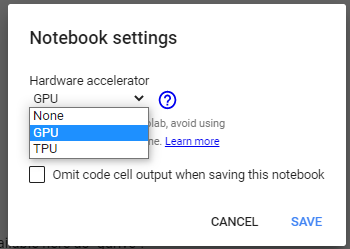

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


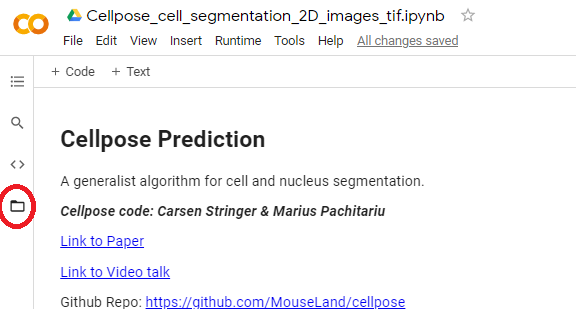

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

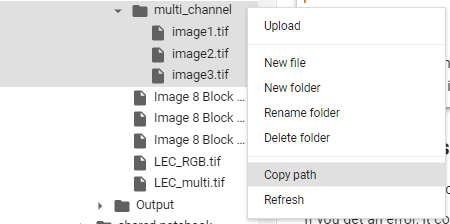

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [2]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-1h57odo4
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-1h57odo4
  Resolved https://www.github.com/mouseland/cellpose.git to commit d95f58a6676362d4e625076e55cd73b47c3bae26
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 57.0 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.7.dev14+gd95f58a66-py3-none-any.whl size=212496 sha256=2aa6650c28e2b6918a4c25b6597dd0e57a68cbeff83c870ef7a89ae5903034b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-h09obchv/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


Check GPU and instantiate model - will download weights.

In [32]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

creating new log file
2025-08-20 20:40:36,059 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-08-20 20:40:36,060 [INFO] 
cellpose version: 	4.0.7.dev14+gd95f58a66 
platform:       	linux 
python version: 	3.12.11 
torch version:  	2.8.0+cu126
2025-08-20 20:40:36,277 [INFO] ** TORCH CUDA version installed and working. **
2025-08-20 20:40:36,278 [INFO] ** TORCH CUDA version installed and working. **
2025-08-20 20:40:36,280 [INFO] >>>> using GPU (CUDA)
2025-08-20 20:40:38,964 [INFO] Downloading: "https://huggingface.co/mouseland/cellpose-sam/resolve/main/cpsam" to /root/.cellpose/models/cpsam



100%|██████████| 1.15G/1.15G [00:06<00:00, 204MB/s]


Input directory with your images:

In [5]:
# *** change to your google drive folder path ***
dir = "/content/data/blue"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".jpg"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

10 images in folder:
B2AI_1_Paclitaxel_A1_R2_z01_blue.jpg
B2AI_1_Paclitaxel_A1_R5_z01_blue.jpg
B2AI_1_Paclitaxel_A1_R6_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R5_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R7_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R11_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R12_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R14_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R17_z01_blue.jpg
B2AI_1_Paclitaxel_A2_R18_z01_blue.jpg


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [6]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (2048, 2048, 3). Assuming channel dimension is last with 3 channels


### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [7]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

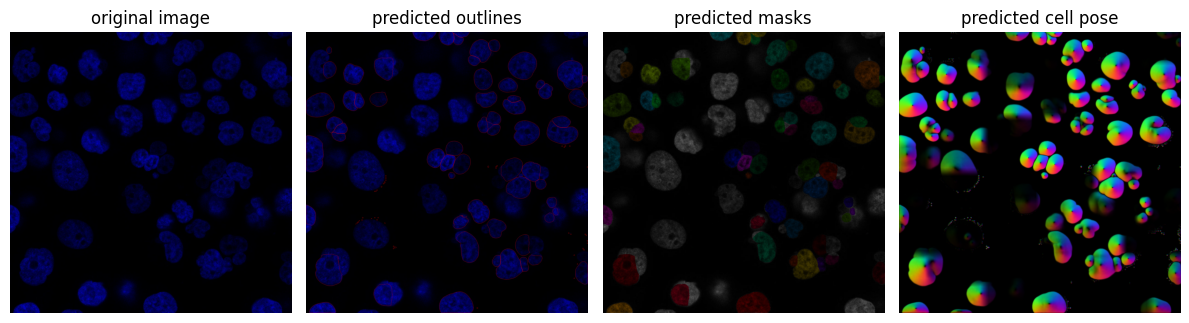

In [8]:
selected_channels = []
for i, c in enumerate([first_channel, second_channel, third_channel]):
  if c == 'None':
    continue
  if int(c) > img.shape[-1]:
    assert False, 'invalid channel index, must have index greater or equal to the number of channels'
  if c != 'None':
    selected_channels.append(int(c))



img_selected_channels = np.zeros_like(img)
img_selected_channels[:, :, :len(selected_channels)] = img[:, :, selected_channels]


flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img_selected_channels, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_selected_channels, masks, flows[0])
plt.tight_layout()
plt.show()


## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [9]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

100%|██████████| 10/10 [06:14<00:00, 37.40s/it]


if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [16]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

loading images


100%|██████████| 10/10 [00:00<00:00, 51.87it/s]

running cellpose-SAM
2025-08-20 20:52:40,853 [INFO] 0%|          | 0/10 [00:00<?, ?it/s]


2025-08-20 20:58:54,622 [INFO] 100%|##########| 10/10 [06:13<00:00, 37.38s/it]
saving masks


100%|██████████| 10/10 [00:00<00:00, 48.89it/s]


to save your masks for ImageJ, run the following code:
-Edited by MMS
---



In [18]:
from pathlib import Path
from cellpose import io
from tqdm import trange

output_dir = Path("/content/cellpose_results/blue")
output_dir.mkdir(parents=True, exist_ok=True)

for i in trange(len(files)):
    f = files[i]

    # use your existing masks array from segmentation
    mask_array = masks[i]

    # save the mask image
    mask_path = output_dir / (f.stem + "_masks" + masks_ext)
    io.imsave(mask_path, mask_array)

    # optionally save ROIs
    io.save_rois(mask_array, mask_path)


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


I wanted to save this instead so that the setup is ready for the cropping pipeline

In [19]:
from pathlib import Path
from cellpose import io
from tqdm import trange

# --- Define output folder ---
main_output = Path("/content/cellpose_results2")
sub_output = main_output / "blue"
sub_output.mkdir(parents=True, exist_ok=True)  # create folder if it doesn't exist

# --- Save existing masks ---
masks_ext = ".png" if image_ext == ".png" else ".tif"

for i in trange(len(files)):
    f = files[i]
    # assume masks is a list or array of masks in the same order as files
    io.imsave(sub_output / (f.stem + "_masks" + masks_ext), masks[i])

print("All masks saved to", sub_output)


100%|██████████| 10/10 [00:00<00:00, 25.91it/s]

All masks saved to /content/cellpose_results2/blue


In [21]:
from pathlib import Path
from tifffile import imread
from PIL import Image
import numpy as np

mask_folder = Path("/content/cellpose_results2/blue")
png_folder = mask_folder / "png"
png_folder.mkdir(exist_ok=True)

for mask_file in mask_folder.glob("*_masks*.tif"):  # or "*.tif" if all are TIFFs
    mask = imread(mask_file)

    # normalize to 0-255 for 8-bit PNG
    mask = mask.astype(np.float32)
    mask = 255 * (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.astype(np.uint8)

    Image.fromarray(mask).save(png_folder / (mask_file.stem + ".png"))

print("Masks converted to PNGs!")


Masks converted to PNGs!


In [22]:
#Now for the other colors. I'll start with red

In [33]:
dir = "/content/data/red"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".jpg"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

10 images in folder:
B2AI_1_Paclitaxel_A1_R2_z01_red.jpg
B2AI_1_Paclitaxel_A1_R5_z01_red.jpg
B2AI_1_Paclitaxel_A1_R6_z01_red.jpg
B2AI_1_Paclitaxel_A2_R5_z01_red.jpg
B2AI_1_Paclitaxel_A2_R7_z01_red.jpg
B2AI_1_Paclitaxel_A2_R11_z01_red.jpg
B2AI_1_Paclitaxel_A2_R12_z01_red.jpg
B2AI_1_Paclitaxel_A2_R14_z01_red.jpg
B2AI_1_Paclitaxel_A2_R17_z01_red.jpg
B2AI_1_Paclitaxel_A2_R18_z01_red.jpg


In [34]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (2048, 2048, 3). Assuming channel dimension is last with 3 channels


In [35]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

In [36]:
flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)


100%|██████████| 10/10 [06:09<00:00, 36.98s/it]


In [37]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])


loading images


100%|██████████| 10/10 [00:00<00:00, 55.03it/s]

running cellpose-SAM
2025-08-20 21:29:38,028 [INFO] 0%|          | 0/10 [00:00<?, ?it/s]


2025-08-20 21:35:46,983 [INFO] 100%|##########| 10/10 [06:08<00:00, 36.90s/it]
saving masks


100%|██████████| 10/10 [00:00<00:00, 51.54it/s]


In [38]:
from pathlib import Path
from cellpose import io
from tqdm import trange

output_dir = Path("/content/cellpose_results2/red")
output_dir.mkdir(parents=True, exist_ok=True)

for i in trange(len(files)):
    f = files[i]

    # use your existing masks array from segmentation
    mask_array = masks[i]

    # save the mask image
    mask_path = output_dir / (f.stem + "_masks" + masks_ext)
    io.imsave(mask_path, mask_array)

    # optionally save ROIs
    io.save_rois(mask_array, mask_path)

100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


In [39]:
from pathlib import Path
from tifffile import imread
from PIL import Image
import numpy as np

mask_folder = Path("/content/cellpose_results2/red")
png_folder = mask_folder / "png"
png_folder.mkdir(exist_ok=True)

for mask_file in mask_folder.glob("*_masks*.tif"):  # or "*.tif" if all are TIFFs
    mask = imread(mask_file)

    # normalize to 0-255 for 8-bit PNG
    mask = mask.astype(np.float32)
    mask = 255 * (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.astype(np.uint8)

    Image.fromarray(mask).save(png_folder / (mask_file.stem + ".png"))

print("Masks converted to PNGs!")

Masks converted to PNGs!


In [ ]:
#Finally, we'll finish with yellow

In [40]:
dir = "/content/data/yellow"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".jpg"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

10 images in folder:
B2AI_1_Paclitaxel_A1_R2_z01_yellow.jpg
B2AI_1_Paclitaxel_A1_R5_z01_yellow.jpg
B2AI_1_Paclitaxel_A1_R6_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R5_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R7_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R11_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R12_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R14_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R17_z01_yellow.jpg
B2AI_1_Paclitaxel_A2_R18_z01_yellow.jpg


In [41]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

your image has shape: (2048, 2048, 3). Assuming channel dimension is last with 3 channels


In [42]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '1' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = '2' # @param ['None', 0, 1, 2, 3, 4, 5]

In [43]:
flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks)

100%|██████████| 10/10 [06:22<00:00, 38.29s/it]


In [44]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

loading images


100%|██████████| 10/10 [00:00<00:00, 47.95it/s]

running cellpose-SAM
2025-08-20 21:43:44,837 [INFO] 0%|          | 0/10 [00:00<?, ?it/s]


2025-08-20 21:50:06,928 [INFO] 100%|##########| 10/10 [06:22<00:00, 38.21s/it]
saving masks


100%|██████████| 10/10 [00:00<00:00, 27.29it/s]


In [45]:
from pathlib import Path
from cellpose import io
from tqdm import trange

output_dir = Path("/content/cellpose_results2/yellow")
output_dir.mkdir(parents=True, exist_ok=True)

for i in trange(len(files)):
    f = files[i]

    # use your existing masks array from segmentation
    mask_array = masks[i]

    # save the mask image
    mask_path = output_dir / (f.stem + "_masks" + masks_ext)
    io.imsave(mask_path, mask_array)

    # optionally save ROIs
    io.save_rois(mask_array, mask_path)

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


In [46]:
from pathlib import Path
from tifffile import imread
from PIL import Image
import numpy as np

mask_folder = Path("/content/cellpose_results2/yellow")
png_folder = mask_folder / "png"
png_folder.mkdir(exist_ok=True)

for mask_file in mask_folder.glob("*_masks*.tif"):  # or "*.tif" if all are TIFFs
    mask = imread(mask_file)

    # normalize to 0-255 for 8-bit PNG
    mask = mask.astype(np.float32)
    mask = 255 * (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.astype(np.uint8)

    Image.fromarray(mask).save(png_folder / (mask_file.stem + ".png"))

print("Masks converted to PNGs!")

Masks converted to PNGs!


In [47]:
from google.colab import files
import shutil

# Path to the folder you want to download
folder_path = "/content/cellpose_results2"

# Create a zip archive
shutil.make_archive("/content/cellpose_results2", 'zip', folder_path)

# Download the zip
files.download("/content/cellpose_results2.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>